In [119]:

import matplotlib as mpl
import argparse
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils.storage import DLStorageIterator, STAGE
from utils.preprocessing import BasicPreprocessor, Preprocessed
import numpy as np
import pandas as pd
from time import perf_counter
import re
import logging
import matplotlib.pyplot as plt
from utils import balance
import scipy
import torch
from deepmeg.data.datasets import EpochsDataset
from deepmeg.utils.params import LFCNNParameters
from deepmeg.experimental.params import SPIRITParameters
from deepmeg.preprocessing.transforms import zscore
import scipy as sp

def set_ticks_invisible(ax, side='x'):
    if side == 'x':
        axis = ax.xaxis
    elif side == 'y':
        axis = ax.yaxis
    else:
        raise ValueError(f'Incorret side "{side}", use x or y only')
    for tick in axis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)


def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]

def sample_spherical(x, y, z):
    vec = np.stack([x, y, z], axis=0)
    vec /= np.linalg.norm(vec, axis=0)
    return vec


def get_indices(seq, match_seq):
    indices = []
    seq_dict = {val: i for i, val in enumerate(seq)}
    for el in match_seq:
        indices.append(seq_dict[el])
    return indices


def plot_latent_space(
    latent1: np.ndarray,
    latent2: np.ndarray,
    latent3: np.ndarray,
    target: np.ndarray
):

    assert len({len(i) for i in (latent1, latent2, latent3)}) == 1, f'given latent variables hase different samplings1: {len(latent1)}, {len(latent2)}, {len(latent3)}'
    assert len(target) == len(latent1), f'Target variable course has different sampling: {len(target)} ~ {len(latent1)}'

    xx, yy, zz = sample_spherical(latent1, latent2, latent3)
    # xx, yy, zz = latent1, latent2, latent3
    fig = plt.figure()
    sfig1, sfig2 = fig.subfigures(1, 2, wspace=0.07)

    gs1 = sfig1.add_gridspec(3, 5)
    gs2 = sfig2.add_gridspec(5, 5)

    ax1 = sfig1.add_subplot(gs1[0, :])
    ax2 = sfig1.add_subplot(gs1[1, :])
    ax3 = sfig1.add_subplot(gs1[2, :])

    ax1.plot(target, latent1)
    ax1.set_ylabel('latent 1')
    set_ticks_invisible(ax1)
    ax2.plot(target, latent2)
    ax2.set_ylabel('latent 2')
    set_ticks_invisible(ax2)
    ax3.plot(target, latent3)
    ax3.set_ylabel('latent 3')
    ax3.set_xlabel('time')

    ax4 = sfig2.add_subplot(gs2[:, :], projection='3d')

    m = ax4.scatter(
        xx, yy, zz,
        c=target,
        cmap='cool'
    )
    # m = ax4.plot(
    #     xx, yy, zz,
    # )
    ax4.set_xlabel('latent 1')
    ax4.set_ylabel('latent 2')
    ax4.set_zlabel('latent 3')

    ax5 = sfig2.add_subplot(gs2[0, 0:2])

    c = ax5.imshow(
        np.corrcoef(np.stack([
            latent1,
            latent2,
            latent3
        ])),
        cmap='seismic',
        vmin=-1, vmax=1
    )
    set_ticks_invisible(ax5, side='x')
    set_ticks_invisible(ax5, side='y')

    plt.colorbar(m, ax=ax4, location='bottom', aspect=50, fraction=0.02)
    plt.colorbar(c, ax=ax5, location='right')

    return fig


In [22]:
time_courses_filtered.shape

(84, 8, 300)

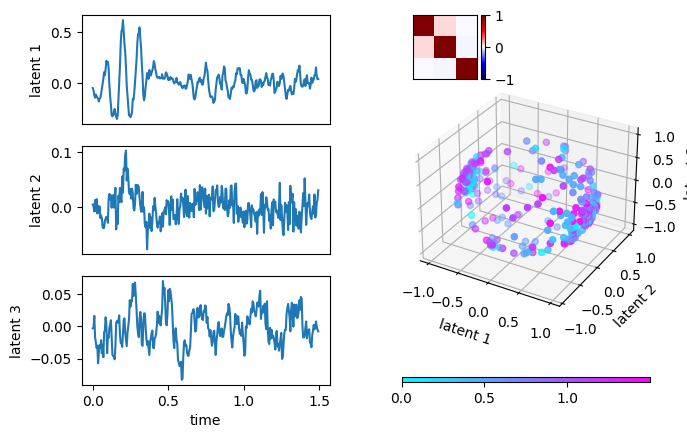

In [219]:
%matplotlib qt

# 2* 3 5 11* 14 15 17 18 21 24 27* 30

i = 15

subject_num = str(i) if len(str(i)) == 2 else f'0{i}'

# params_path = f'../../spatual/RESULTS/sbj{subject_num}/training_acc_lfcnnw/params.pkl'
params_path = f'../../spatual/RESULTS/sbj{subject_num}/00_training_acc_lfcnnw_indep_sources/params.pkl'

params = SPIRITParameters.load(params_path)
time_courses_filtered = params.temporal.time_courses_filtered[:, np.argsort(params.order)[::-1], :]

indices = (0, 1, 2)

plot_latent_space(
    # sp.stats.zscore(time_courses_filtered.mean(0)[0]),
    # sp.stats.zscore(time_courses_filtered.mean(0)[6]),
    # sp.stats.zscore(time_courses_filtered.mean(0)[7]),
    time_courses_filtered.mean(0)[indices[0]] - time_courses_filtered.mean(0)[indices[0]][150:250].mean(),
    time_courses_filtered.mean(0)[indices[1]] - time_courses_filtered.mean(0)[indices[1]][150:250].mean(),
    time_courses_filtered.mean(0)[indices[2]] - time_courses_filtered.mean(0)[indices[2]][150:250].mean(),
    # time_courses_filtered[0][indices[0]] - time_courses_filtered[0][indices[0]][150:250].mean(),
    # time_courses_filtered[0][indices[1]] - time_courses_filtered[0][indices[1]][150:250].mean(),
    # time_courses_filtered[0][indices[2]] - time_courses_filtered[0][indices[2]][150:250].mean(),
    # time_courses_filtered.mean(0)[0],
    # time_courses_filtered.mean(0)[1],
    # time_courses_filtered.mean(0)[2],
    params.temporal.times
)

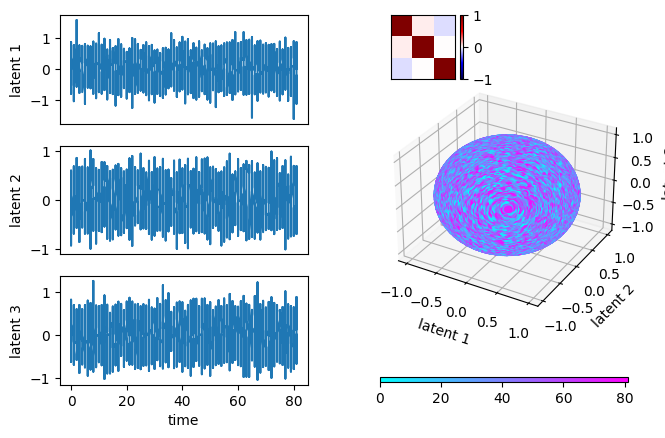

In [187]:
i = 4

subject_num = str(i) if len(str(i)) == 2 else f'0{i}'

# params_path = f'../../spatual/RESULTS/sbj{subject_num}/training_acc_lfcnnw/params.pkl'
params_path = f'../../spatual/RESULTS/sbj{subject_num}/00_training_acc_lfcnnw_indep_sources/params.pkl'

params = SPIRITParameters.load(params_path)
time_courses_filtered = params.temporal.time_courses_filtered[:, np.argsort(params.order)[::-1], :]

n_epochs = time_courses_filtered.shape[0]

time_courses_filtered -= time_courses_filtered[:, :, 150:250].mean(-1, keepdims=True)

# n_epochs = 5

time_courses_filtered = np.reshape(np.transpose(time_courses_filtered[:n_epochs, :, :], (1, 0, -1)), (8, -1))
times = np.tile(params.temporal.times, n_epochs)
# times = np.repeat(np.arange(n_epochs), len(params.temporal.times))

indices = (0, 1, 2)

plot_latent_space(
    # sp.stats.zscore(time_courses_filtered.mean(0)[0]),
    # sp.stats.zscore(time_courses_filtered.mean(0)[6]),
    # sp.stats.zscore(time_courses_filtered.mean(0)[7]),
    # time_courses_filtered.mean(0)[indices[0]] - time_courses_filtered.mean(0)[indices[0]][150:250].mean(),
    # time_courses_filtered.mean(0)[indices[1]] - time_courses_filtered.mean(0)[indices[1]][150:250].mean(),
    # time_courses_filtered.mean(0)[indices[2]] - time_courses_filtered.mean(0)[indices[2]][150:250].mean(),
    time_courses_filtered[indices[0]],
    time_courses_filtered[indices[1]],
    time_courses_filtered[indices[2]],
    # time_courses_filtered.mean(0)[0],
    # time_courses_filtered.mean(0)[1],
    # time_courses_filtered.mean(0)[2],
    times
)

In [ ]:
%matplotlib inline
# params_path = '../../spatual/RESULTS/sbj02/action_lfcnnw/params.pkl'
params_path = '../../spatual/RESULTS/sbj21/training_acc_lfcnnw/params.pkl'
# params_path = '../../spatual/RESULTS/sbj21/training_acc_lfcnnw/params.pkl'
params = SPIRITParameters.load(params_path)

interp_cubic = lambda y, n: sp.interpolate.interp1d(params.temporal.times, y, 'cubic')(np.linspace(params.temporal.times[0], params.temporal.times[-1], n))

time_courses_filtered = params.temporal.time_courses_filtered[:, np.argsort(params.order)[::-1], :]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(params.temporal.times, time_courses_filtered.mean(0)[0])
ax2.plot(params.temporal.times, time_courses_filtered.mean(0)[1])
ax3.plot(params.temporal.times, time_courses_filtered.mean(0)[2])

In [234]:
plt.plot(t, interp_cubic(time_courses_filtered.mean(0)[0], n), t, xx)
plt.legend(['without', 'with'])

In [2]:
project_name = 'project_name'
subjects_dir = '../../spatual/Preprocessed/'
classification_name_formatted = 'testname'

iterator = DLStorageIterator(subjects_dir, name=classification_name_formatted)

In [13]:
next(iterator)

'sbj02'

In [189]:
import pandas as pd
i = 7

subject_num = str(i) if len(str(i)) == 2 else f'0{i}'

# params_path = f'../../spatual/RESULTS/sbj{subject_num}/training_acc_lfcnnw/params.pkl'
params_path = f'../../spatual/RESULTS/sbj{subject_num}/01_training_acc_lfcnnw_indep_sources/params.pkl'
testsesinfo_path = f'../../spatual/RESULTS/sbj{subject_num}/01_training_acc_lfcnnw_indep_sources/test_session_info.csv'

params = SPIRITParameters.load(params_path)
testsesinfo = pd.read_csv(testsesinfo_path, index_col=0)
time_courses_filtered = params.temporal.time_courses_filtered[:, np.argsort(params.order)[::-1], :]

indices = (0, 1, 2)
testsesinfo.index.min(), np.median(testsesinfo.index), testsesinfo.index.max()

ind_dict = dict(enumerate(testsesinfo.index))
ind_dict = dict(sorted(ind_dict.items(), key=lambda item: item[1]))
epochs_indices = list(ind_dict.keys())

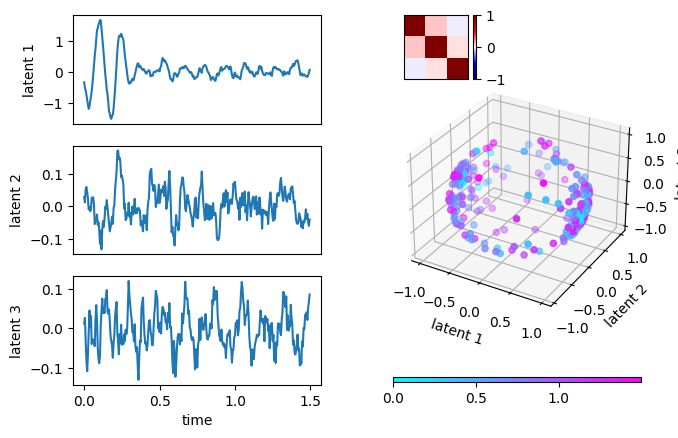

In [185]:
%matplotlib qt
indices = (0, 1, 2)
seed = 1
plot_latent_space(
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)].mean(0)[indices[0]] -
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)].mean(0)[indices[0]][150:250].mean(),
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)].mean(0)[indices[1]] -
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)].mean(0)[indices[1]][150:250].mean(),
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)].mean(0)[indices[2]] -
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)].mean(0)[indices[2]][150:250].mean(),
    params.temporal.times
)

seed = 2
plot_latent_space(
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)].mean(0)[indices[0]] -
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)].mean(0)[indices[0]][150:250].mean(),
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)].mean(0)[indices[1]] -
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)].mean(0)[indices[1]][150:250].mean(),
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)].mean(0)[indices[2]] -
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)].mean(0)[indices[2]][150:250].mean(),
    params.temporal.times
)

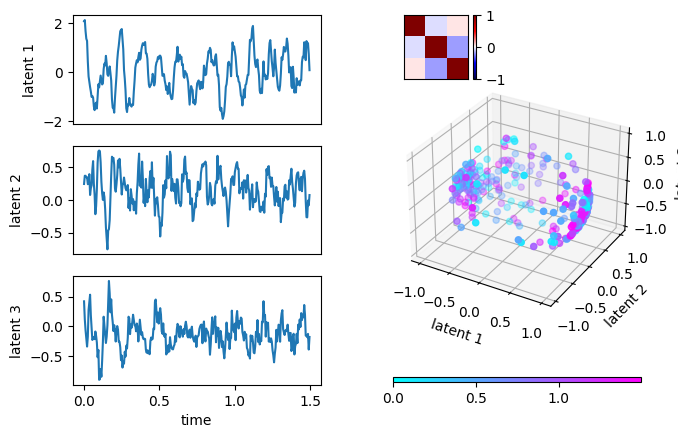

In [188]:
%matplotlib qt
indices = (0, 1, 2)
n = 0
seed = 1
epochs_indices_ = np.array(epochs_indices)[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)]

plot_latent_space(
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)][np.argsort(epochs_indices_)][n][indices[0]],# -
    # time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)][np.argsort(epochs_indices_)][n][indices[0]][150:250].mean(),
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)][np.argsort(epochs_indices_)][n][indices[1]],# -
    # time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)][np.argsort(epochs_indices_)][n][indices[1]][150:250].mean(),
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)][np.argsort(epochs_indices_)][n][indices[2]],# -
    # time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)][np.argsort(epochs_indices_)][n][indices[2]][150:250].mean(),
    params.temporal.times
)

seed = 1
n=-1
epochs_indices_ = np.array(epochs_indices)[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)]

plot_latent_space(
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)][np.argsort(epochs_indices_)][n][indices[0]],# -
    # time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)][np.argsort(epochs_indices_)][n][indices[0]][150:250].mean(),
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)][np.argsort(epochs_indices_)][n][indices[1]],# -
    # time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)][np.argsort(epochs_indices_)][n][indices[1]][150:250].mean(),
    time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)][np.argsort(epochs_indices_)][n][indices[2]],# -
    # time_courses_filtered[get_indices(testsesinfo.index, testsesinfo[testsesinfo.Seed == seed].index)][np.argsort(epochs_indices_)][n][indices[2]][150:250].mean(),
    params.temporal.times
)

In [404]:
def plot_spectra(data, ax, cmap, vmin, vmax, cmin, cmax):

    pos = ax.imshow(
        data,
        origin='lower',
        cmap=cmap,
        interpolation='bicubic',
        aspect='auto',
        interpolation_stage='rgba',
        vmin=vmin,
        vmax=vmax
    )

    ax.contour(
        data,
        [
            cmin,
            cmax
        ],
        origin='lower',
        linewidths=.1,
        cmap=cmap,
    )


class ButtonPressCallback:
    def __init__(self, fig, ax, data, index, borders, cmap, d=None):
        self.fig = fig
        self.ax = ax
        self.data = data
        self.index = index
        self.d = d
        self.vmin, self.vmax, self.cmin, self.cmax = borders
        self.cmap = cmap
    def __call__(self, event):
        if event.key in ('right', 'up'):
            self.index += 1
        elif event.key in ('left', 'down'):
            self.index -= 1
        else:
            print(event.__dict__)

        self.refresh()

    def refresh(self):

        total_len = len(self.data)

        index = self.index%total_len

        if self.d is not None:
            from_ = max(index - self.d, 0)
            to = min(index + self.d, total_len)
        else:
            from_ = index
            to = from_ + 1

        vmin, vmax, cmin, cmax = tuple(np.percentile(self.data[from_:to].mean(0), (1, 99, 25, 75)))

        self.ax.clear()
        plot_spectra(self.data[from_:to].mean(0), self.ax, self.cmap, vmin, vmax, cmin, cmax)

        self.fig.suptitle(f'Epoch {from_}:{to}')
        self.fig.canvas.draw()


class CrossMovementCallback:
    def __init__(self, fig, ax, x, y, p, index, d=None):
        self.fig = fig
        self.x = x
        self.y = y
        self.p = p
        self.ax = ax
        self.index = index
        self.d = d

    def __call__(self, event):
        if event.key in ('right', 'up'):
            self.index += 1
        elif event.key in ('left', 'down'):
            self.index -= 1
        else:
            print(event.__dict__)

        self.refresh()

    def refresh(self):

        total_len = len(self.x)

        index = self.index%total_len

        if self.d is not None:
            from_ = max(index - self.d, 0)
            to = min(index + self.d, total_len)
        else:
            from_ = index
            to = from_ + 1

        self.ax.clear()
        self.ax.plot(self.x, self.y, self.x, self.y, 'x')
        self.ax.plot(self.x[from_:to], self.y[from_:to], 'x', color='red')
        self.ax.plot(self.x, self.p, 'x')
        self.fig.canvas.draw()


In [406]:
i = 3

subject_num = str(i) if len(str(i)) == 2 else f'0{i}'

params_path = f'../../spatual/RESULTS/sbj{subject_num}/01_training_acc_lfcnnw_indep_sources/params.pkl'
preds_path = f'../../spatual/RESULTS/sbj{subject_num}/01_training_acc_lfcnnw_indep_sources/preds.pkl'
testsesinfo_path = f'../../spatual/RESULTS/sbj{subject_num}/01_training_acc_lfcnnw_indep_sources/test_session_info.csv'

params = SPIRITParameters.load(params_path)
preds = SPIRITParameters.load(preds_path)
testsesinfo = pd.read_csv(testsesinfo_path, index_col=0)

sesinfo_index_2_epochs_number = dict(enumerate(testsesinfo.index)) # index in sesinfo.iloc to index in all epochs (epochs = sp + con)
epochs_number_2_sesinfo_index = {v: k for k, v in sesinfo_index_2_epochs_number.items()}  # index in all epochs to sesinfo.iloc

sp_epochs_indices = sorted(testsesinfo[testsesinfo.Seed == 1].index.to_list()) # indices of spatial epochs sorted
con_epochs_indices = sorted(testsesinfo[testsesinfo.Seed == 2].index.to_list()) # indices of conceptual epochs sorted

sp_indices = [epochs_number_2_sesinfo_index[epoch_index] for epoch_index in sp_epochs_indices] # indices in sesinfo of sorted spatial epochs
con_indices = [epochs_number_2_sesinfo_index[epoch_index] for epoch_index in con_epochs_indices] # indices in sesinfo of sorted conceptual epochs

induceds= params.temporal.induceds[np.argsort(params.order)[::-1], :, :] # induceds sorted according to their relevace
induceds_filtered = params.temporal.induceds_filtered[np.argsort(params.order)[::-1], :, :] # filtered induceds sorted according to their relevace

sp_induceds = induceds[:, sp_indices, :]
sp_induceds_filtered = induceds_filtered[:, sp_indices, :]

con_induceds = induceds[:, con_indices, :]
con_induceds_filtered = induceds_filtered[:, con_indices, :]

preds = preds.y_p[sp_indices]

In [407]:
from deepmeg.preprocessing.transforms import rowwise_zscore
from deepmeg.utils.colors import generate_cmap
import time
n_branch = 0
sp_induceds_norm = (sp_induceds[n_branch] - sp_induceds[n_branch].mean(-1, keepdims=True))/sp_induceds[n_branch].std(-1, keepdims=True)
sp_induceds_norm_filt = (sp_induceds_filtered[n_branch] - sp_induceds_filtered[n_branch].mean(-1, keepdims=True))/sp_induceds_filtered[n_branch].std(-1, keepdims=True)


sp_acc = testsesinfo.acc.iloc[sp_indices]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)
cmap = generate_cmap(
    '#1f77b4',
    '#ffffff',
    '#d62728'
)
vmin, vmax, cmin, cmax = tuple(np.percentile(sp_induceds_norm_filt, (1, 99, 25, 75)))

sp_induceds_norm_filt = sp_induceds_norm_filt[:, :, 25:-25]
sp_induceds_norm = sp_induceds_norm[:, :, 25:-25]

plot_spectra(sp_induceds_norm_filt[0], ax1, cmap, vmin, vmax, cmin, cmax)
# plot_spectra(sp_induceds_norm_filt[0], ax2, cmap, vmin, vmax, cmin, cmax)
ax2.plot(sp_acc.index, sp_acc, sp_acc.index, sp_acc, 'x')
ax2.plot(sp_acc.index.to_list()[0], sp_acc.iloc[0], 'x', color='red')
ax2.plot(sp_acc.index, preds, 'x', color='green')

fig.suptitle(f'Epoch {0}')


callback =  ButtonPressCallback(fig, ax1, sp_induceds_norm_filt, 0, (vmin, vmax, cmin, cmax), cmap, None)
fig.canvas.mpl_connect('key_press_event', callback)
fig.canvas.mpl_connect('key_press_event', CrossMovementCallback(fig, ax2, sp_acc.index.to_list(), sp_acc.to_list(), preds, 0, None))


15

In [197]:
induceds_filtered.shape

(8, 83, 99, 300)

In [190]:
params.temporal.induceds_filtered.shape

(8, 83, 99, 300)

In [178]:
con_induceds_filtered.shape, sp_induceds_filtered.shape, induceds_filtered.shape

((8, 41, 300), (8, 42, 300), (8, 99, 300))

In [184]:
params.temporal._asdict().keys()

dict_keys(['times', 'time_courses', 'time_courses_filtered', 'induceds', 'induceds_filtered', 'patterns'])

In [183]:
len(testsesinfo),

(83,)